In [3]:
import pandas as pd
import numpy as np
import ast
import re
import math
import json
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
# transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [ ]:
# Load data from previously generated offer_agg dataframe (stored in XLSX format)
offer_agg = pd.read_excel('../misc/offer_agg-281124-004532 - Copy.xlsx')   
offer_agg.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

 # Exploratory Data Analysis

In [6]:
# Group dataframe offer_agg by 'offer_id' and aggregate the required columns
result = offer_agg.groupby('offer_id').agg({
    'offer_rcvd_time': 'count',
    'offer_view_time': 'count',
    'offer_cmpl_time': 'count',
    'offer_trx_amount': 'sum'
}).reset_index()

print(result.columns)

# Rename columns to match the desired names
result.rename(columns={
    'offer_rcvd_time': 'count_offer_rcvd',
    'offer_view_time': 'count_offer_view',
    'offer_cmpl_time': 'count_offer_cmpl',
    'offer_trx_amount': 'sum_offer_trx_amount'
}, inplace=True)

print(result.columns)

result['trx_amount_per_offer_rcvd'] = result['sum_offer_trx_amount'] / result['count_offer_rcvd']
result['trx_amount_per_offer_compl'] = result['sum_offer_trx_amount'] / result['count_offer_cmpl']

Index(['offer_id', 'offer_rcvd_time', 'offer_view_time', 'offer_cmpl_time',
       'offer_trx_amount'],
      dtype='object')
Index(['offer_id', 'count_offer_rcvd', 'count_offer_view', 'count_offer_cmpl',
       'sum_offer_trx_amount'],
      dtype='object')


In [7]:
result

,offer_id,count_offer_rcvd,count_offer_view,count_offer_cmpl,sum_offer_trx_amount,trx_amount_per_offer_rcvd,trx_amount_per_offer_compl
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,7668,1517,3313,74315.65,9.691660,22.431527
1,2298d6c36e964ae4a3e7e9706d1fb8c2,7646,5379,5102,80465.02,10.523806,15.771270
2,2906b810c7d4411798c6938adc9daaa5,7632,2514,3955,69820.06,9.148331,17.653618
3,4d5c57ea9a6940dd891ad53e9dbe8da0,7593,3760,3301,74507.30,9.812630,22.571130
4,9b98b8c7a33c4b65b9aebfe6a799e6d9,7677,2514,4303,70142.70,9.136733,16.300883
5,ae264e3637204a6fb9bb56bc8210ddfd,7658,3767,3635,82046.15,10.713783,22.571155
6,f19421c1d4aa40978ebb69ca19b0e20d,7571,4290,4262,76836.77,10.148827,18.028336
7,fafdcd668e3743c1bb461111dcafc2a4,7597,5540,5230,84327.52,11.100108,16.123809


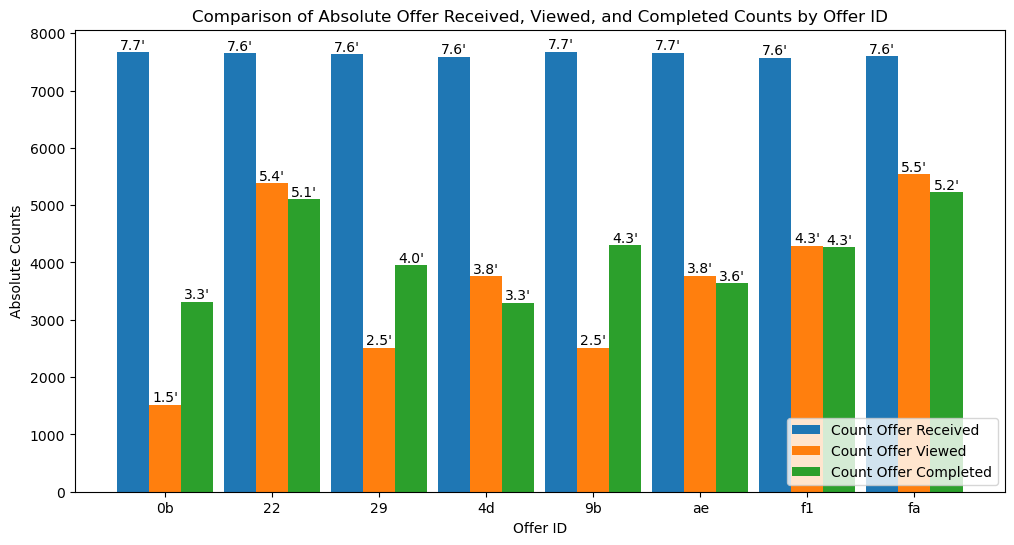

In [8]:
# Create a bar graph to compare absolute values of count_offer_rcvd, count_offer_view, count_offer_cmpl for each offer_id

# Set the figure size
plt.figure(figsize=(12, 6))

# Set the positions and width for the bars
positions = range(len(result))
width = 0.3

# Plot the bars
bars1 = plt.bar(positions, result['count_offer_rcvd'], width=width, label='Count Offer Received')
bars2 = plt.bar([p + width for p in positions], result['count_offer_view'], width=width, label='Count Offer Viewed')
bars3 = plt.bar([p + width * 2 for p in positions], result['count_offer_cmpl'], width=width, label='Count Offer Completed')

# Add the values on top of each bar
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval/1000:.1f}'", ha='center', va='bottom')

for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval/1000:.1f}'", ha='center', va='bottom')

for bar in bars3:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval/1000:.1f}'", ha='center', va='bottom')

# Set the x-axis labels and positions
plt.xlabel('Offer ID')
plt.ylabel('Absolute Counts')
plt.title('Comparison of Absolute Offer Received, Viewed, and Completed Counts by Offer ID')
plt.xticks([p + width for p in positions], result['offer_id'].str[:2])

# Add legend and move it to the bottom right corner
plt.legend(loc='lower right')

# Show the plot
plt.show()

### Absolute counts of offer received, offer viewed and offer completed

*Distribution of offer ids in transcript dataset:* <br>
*As the bar graphs above are showing the various offers are nearly evenly distributed in the transcript data set.*
<br><br>
*Count offer views vs. count offer completed anomaly:* <br>
*For offers '0b', '29', '9b' there are many offers, which are not viewed prior to their completion. This was already detected in the test data (see discusion above).*

In [9]:
portfolio['reward_difficulty_quotient'] = round(portfolio['reward'] / portfolio['difficulty'], 2)
portfolio

,reward,channels,difficulty,duration,offer_type,id,reward_difficulty_quotient
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1.00
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1.00
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,NaN
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.00
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.25
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,0.43
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,0.20
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,NaN
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1.00
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,0.20


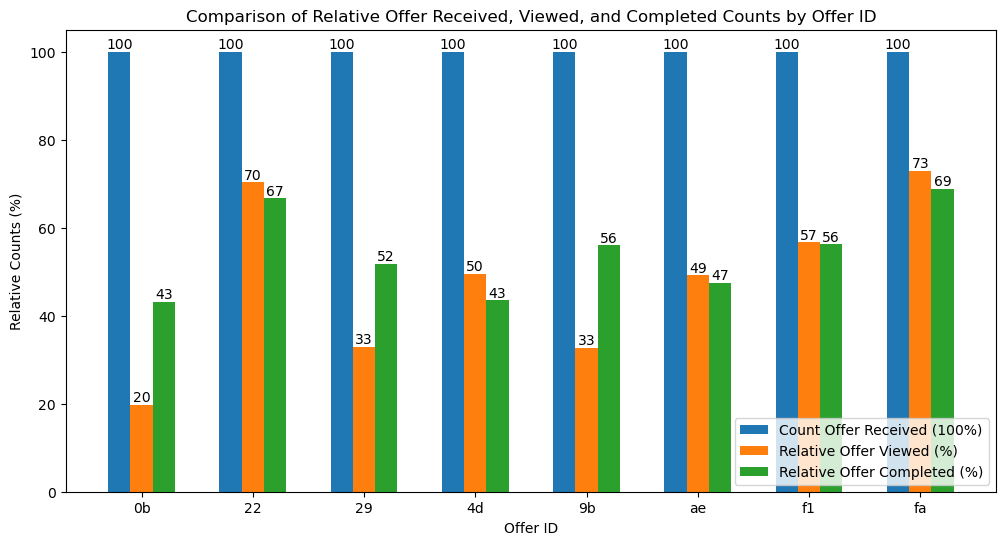

In [10]:
import matplotlib.pyplot as plt

# Create a bar graph to compare count_offer_view, count_offer_cmpl for each offer_id relatively to count_offer_rcvd

# Calculate relative values where count_offer_rcvd is 100%
result['relative_offer_view'] = (result['count_offer_view'] / result['count_offer_rcvd']) * 100
result['relative_offer_cmpl'] = (result['count_offer_cmpl'] / result['count_offer_rcvd']) * 100

# Set the figure size
plt.figure(figsize=(12, 6))

# Set the positions and width for the bars
positions = range(len(result))
width = 0.2

# Plot the bars
bars1 = plt.bar(positions, [100] * len(result), width=width, label='Count Offer Received (100%)')
bars2 = plt.bar([p + width for p in positions], result['relative_offer_view'], width=width, label='Relative Offer Viewed (%)')
bars3 = plt.bar([p + width * 2 for p in positions], result['relative_offer_cmpl'], width=width, label='Relative Offer Completed (%)')

# Add the values on top of each bar
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.0f}', ha='center', va='bottom')

for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.0f}', ha='center', va='bottom')

for bar in bars3:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.0f}', ha='center', va='bottom')

# Set the x-axis labels and positions
plt.xlabel('Offer ID')
plt.ylabel('Relative Counts (%)')
plt.title('Comparison of Relative Offer Received, Viewed, and Completed Counts by Offer ID')
plt.xticks([p + width for p in positions], result['offer_id'].str[:2])

# Add legend
plt.legend(loc='lower right')

# Show the plot
plt.show()

In [11]:
result

,offer_id,count_offer_rcvd,count_offer_view,count_offer_cmpl,sum_offer_trx_amount,trx_amount_per_offer_rcvd,trx_amount_per_offer_compl,relative_offer_view,relative_offer_cmpl
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,7668,1517,3313,74315.65,9.691660,22.431527,19.783516,43.205529
1,2298d6c36e964ae4a3e7e9706d1fb8c2,7646,5379,5102,80465.02,10.523806,15.771270,70.350510,66.727701
2,2906b810c7d4411798c6938adc9daaa5,7632,2514,3955,69820.06,9.148331,17.653618,32.940252,51.821279
3,4d5c57ea9a6940dd891ad53e9dbe8da0,7593,3760,3301,74507.30,9.812630,22.571130,49.519294,43.474253
4,9b98b8c7a33c4b65b9aebfe6a799e6d9,7677,2514,4303,70142.70,9.136733,16.300883,32.747167,56.050541
5,ae264e3637204a6fb9bb56bc8210ddfd,7658,3767,3635,82046.15,10.713783,22.571155,49.190389,47.466701
6,f19421c1d4aa40978ebb69ca19b0e20d,7571,4290,4262,76836.77,10.148827,18.028336,56.663585,56.293752
7,fafdcd668e3743c1bb461111dcafc2a4,7597,5540,5230,84327.52,11.100108,16.123809,72.923522,68.842964


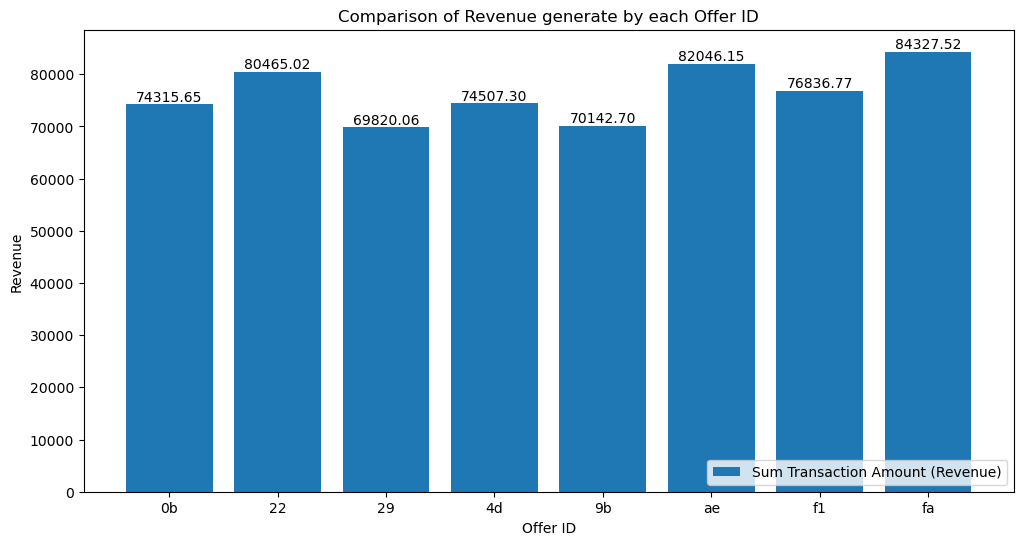

In [12]:
# Create a bar graph to show a comparison of total revenues generate by each offer

# Set the figure size
plt.figure(figsize=(12, 6))

# Set the positions and width for the bars
positions = range(len(result))
# width = 0.2

# Plot the bars
plt.bar(positions, result['sum_offer_trx_amount'], label='Sum Transaction Amount (Revenue)')

# Add the values on top of each bar
for i, value in enumerate(result['sum_offer_trx_amount']):
    plt.text(i, value, f'{value:.2f}', ha='center', va='bottom')

# Set the x-axis labels and positions
plt.xlabel('Offer ID')
plt.ylabel('Revenue')
plt.title('Comparison of Revenue generate by each Offer ID')
plt.xticks([p for p in positions], result['offer_id'].str[:2])

# Add legend
plt.legend(loc='lower right')

# Show the plot
plt.show() 

### Overall performance of the offers based on absolute revenue and relative completion rate

*Relative completion rate:* <br>
*As the bar graphs above are showing the most successful offers regarding relative completion rate are the offers starting with ID 'fa', '22' and '9b'/'f1'.*
<br><br>
*Absolute revenue:* <br>
*Regarding absolute revenue generated the offers 'fa', 'ae' and '22' are the most successful. It is interesting, that offer 'ae' as a relatively low completion rate (47%), but generates the second highest revenue.*

In [13]:
portfolio['reward_difficulty_quotient'] = round(portfolio['reward'] / portfolio['difficulty'], 2)
portfolio

,reward,channels,difficulty,duration,offer_type,id,reward_difficulty_quotient
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1.00
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1.00
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,NaN
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.00
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.25
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,0.43
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,0.20
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,NaN
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1.00
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,0.20


In [17]:
offer_agg.columns

Index(['person', 'gender_M', 'gender_F', 'age', 'became_member_on', 'income',
       'offer_rcvd_time', 'offer_view_time', 'offer_view_time_el',
       'offer_cmpl_time', 'offer_cmpl_time_el', 'offer_id', 'offer_duration',
       'offer_difficulty', 'offer_reward', 'offer_channels_web',
       'offer_channels_email', 'offer_channels_mobile',
       'offer_channels_social', 'offer_type_bogo', 'offer_type_discount',
       'offer_trx_amount'],
      dtype='object')

In [ ]:
# Group dataframe offer_agg by 'offer_id' and aggregate the required columns
result = offer_agg.groupby(['offer_id').agg({
    'offer_rcvd_time': 'count',
    'offer_view_time': 'count',
    'offer_cmpl_time': 'count',
    'offer_trx_amount': 'sum'
}).reset_index()

print(result.columns)

# Rename columns to match the desired names
result.rename(columns={
    'offer_rcvd_time': 'count_offer_rcvd',
    'offer_view_time': 'count_offer_view',
    'offer_cmpl_time': 'count_offer_cmpl',
    'offer_trx_amount': 'sum_offer_trx_amount'
}, inplace=True)

print(result.columns)

result['trx_amount_per_offer_rcvd'] = result['sum_offer_trx_amount'] / result['count_offer_rcvd']
result['trx_amount_per_offer_compl'] = result['sum_offer_trx_amount'] / result['count_offer_cmpl']